In [ ]:
# dataset used - https://www.kaggle.com/datasets/govindaramsriram/crop-yield-of-a-farm

A1. Calculate Entropy

In [1]:
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv("crop_yield_data.csv")

# Function for equal width binning
def equal_width_binning(data, bins=4):
    return pd.cut(data, bins=bins, labels=False, duplicates='drop')

# Function to calculate entropy
def calculate_entropy(binned_data):
    # Get probabilities of each class/bin
    probabilities = binned_data.value_counts(normalize=True)
    # Apply entropy formula: -sigma (p * log2(p))
    entropy = -np.sum(probabilities * np.log2(probabilities))
    return entropy

# Apply equal width binning on crop_yield (target variable)
df['crop_yield_binned'] = equal_width_binning(df['crop_yield'], bins=4)

# Calculate entropy of target variable
entropy_value = calculate_entropy(df['crop_yield_binned'])

print("Binned crop_yield values:\n", df['crop_yield_binned'].value_counts())
print(f"\nEntropy of crop_yield (binned): {entropy_value:.4f}")

Binned crop_yield values:
 crop_yield_binned
2    894
1    837
0    690
3    579
Name: count, dtype: int64

Entropy of crop_yield (binned): 1.9800


A2. Calculate Gini Index

In [2]:
# Calculate Gini index given categorical/binned data.
def calculate_gini(binned_data):
    probabilities = binned_data.value_counts(normalize=True)
    gini = 1 - np.sum(probabilities**2)
    return gini

# Apply binning on crop_yield
df['crop_yield_binned'] = equal_width_binning(df['crop_yield'], bins=4)

# Calculate Gini Index
gini_value = calculate_gini(df['crop_yield_binned'])

print("Binned crop_yield values:\n", df['crop_yield_binned'].value_counts())
print(f"\nGini Index of crop_yield (binned): {gini_value:.4f}")

Binned crop_yield values:
 crop_yield_binned
2    894
1    837
0    690
3    579
Name: count, dtype: int64

Gini Index of crop_yield (binned): 0.7432


A3.

In [3]:
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv("crop_yield_data.csv")

# Equal width binning for continuous features (into 4 bins)
def equal_width_binning(series, bins=4):
    return pd.cut(series, bins=bins, labels=False, duplicates='drop')

# Entropy calculation
def calculate_entropy(data):
    probabilities = data.value_counts(normalize=True)
    entropy = -np.sum(probabilities * np.log2(probabilities + 1e-9))
    return entropy

# Information Gain calculation
def information_gain(df, feature, target):
    total_entropy = calculate_entropy(df[target])
    values = df[feature].unique()

    weighted_entropy = 0
    for val in values:
        subset = df[df[feature] == val][target]
        weight = len(subset) / len(df)
        weighted_entropy += weight * calculate_entropy(subset)

    return total_entropy - weighted_entropy

# Step 1: Bin continuous features + target
df['crop_yield_binned'] = equal_width_binning(df['crop_yield'], bins=4)
features = ['rainfall_mm', 'soil_quality_index', 'farm_size_hectares',
            'sunlight_hours', 'fertilizer_kg']

# Bin each feature
for feature in features:
    df[feature + '_binned'] = equal_width_binning(df[feature], bins=4)

# Step 2: Calculate Information Gain for each feature
ig_scores = {}
for feature in features:
    ig = information_gain(df, feature + '_binned', 'crop_yield_binned')
    ig_scores[feature] = ig

# Step 3: Select feature with max IG as root node
root_feature = max(ig_scores, key=ig_scores.get)

print("Information Gain for each feature:")
for f, score in ig_scores.items():
    print(f"{f}: {score:.4f}")

print(f"\nRoot node based on highest Information Gain: {root_feature}")

Information Gain for each feature:
rainfall_mm: 0.0052
soil_quality_index: 0.0041
farm_size_hectares: 1.3962
sunlight_hours: 0.0008
fertilizer_kg: 0.0071

Root node based on highest Information Gain: farm_size_hectares


A4.

In [5]:
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv("crop_yield_data.csv")

# Custom binning function
def custom_binning(series, n_bins=4, binning_type="equal_width"):
    if binning_type == "equal_width":
        return pd.cut(series, bins=n_bins, labels=False, duplicates="drop")
    elif binning_type == "equal_frequency":
        return pd.qcut(series, q=n_bins, labels=False, duplicates="drop")
    else:
        raise ValueError("Invalid binning_type. Use 'equal_width' or 'equal_frequency'.")

# Example usage with defaults (equal width, 4 bins)
df['rainfall_binned_default'] = custom_binning(df['rainfall_mm'])

# Example usage with equal frequency, 5 bins
df['soil_quality_binned_freq'] = custom_binning(df['soil_quality_index'], n_bins=5, binning_type="equal_frequency")

# Show results
print(df[['rainfall_mm', 'rainfall_binned_default', 'soil_quality_index', 'soil_quality_binned_freq']].head())

   rainfall_mm  rainfall_binned_default  soil_quality_index  \
0         1626                        3                   9   
1         1959                        3                   9   
2         1360                        2                   1   
3         1794                        3                   2   
4         1630                        3                   5   

   soil_quality_binned_freq  
0                         4  
1                         4  
2                         0  
3                         0  
4                         1  


A5.

In [6]:
import pandas as pd
import numpy as np

# ---------- Helper Functions ----------

# Entropy function
def entropy(y):
    values, counts = np.unique(y, return_counts=True)
    probs = counts / len(y)
    return -np.sum(probs * np.log2(probs))

# Information Gain
def information_gain(data, feature, target):
    total_entropy = entropy(data[target])
    values, counts = np.unique(data[feature], return_counts=True)

    weighted_entropy = 0
    for v, c in zip(values, counts):
        subset = data[data[feature] == v]
        weighted_entropy += (c / len(data)) * entropy(subset[target])

    return total_entropy - weighted_entropy

# Find best feature to split
def best_feature(data, target):
    features = [f for f in data.columns if f != target]
    gains = {f: information_gain(data, f, target) for f in features}
    return max(gains, key=gains.get)

# ---------- Decision Tree Function ----------
def build_tree(data, target, depth=0, max_depth=3):
    # If all target values are same -> return that value
    if len(np.unique(data[target])) == 1:
        return np.unique(data[target])[0]

    # If max depth reached -> return most common class
    if depth >= max_depth:
        return data[target].mode()[0]

    # Choose best feature
    feature = best_feature(data, target)
    tree = {feature: {}}

    # Split on each value of best feature
    for value in np.unique(data[feature]):
        subset = data[data[feature] == value]
        subtree = build_tree(subset, target, depth+1, max_depth)
        tree[feature][value] = subtree

    return tree

# ---------- Example ----------
# Load dataset
df = pd.read_csv("crop_yield_data.csv")

# Convert continuous target into 4 bins
df["yield_class"] = pd.cut(df["crop_yield"], bins=4, labels=["low","mid-low","mid-high","high"])

# Convert continuous features into bins (equal width, 3 bins for simplicity)
for col in df.columns[:-2]:  # skip crop_yield and yield_class
    df[col] = pd.cut(df[col], bins=3, labels=[0,1,2])

# Build decision tree
tree = build_tree(df, target="yield_class", max_depth=3)
print("Decision Tree:\n", tree)

Decision Tree:
 {'crop_yield': {np.int64(46): 'low', np.int64(48): 'low', np.int64(50): 'low', np.int64(52): 'low', np.int64(53): 'low', np.int64(56): 'low', np.int64(57): 'low', np.int64(59): 'low', np.int64(61): 'low', np.int64(62): 'low', np.int64(65): 'low', np.int64(67): 'low', np.int64(69): 'low', np.int64(71): 'low', np.int64(72): 'low', np.int64(73): 'low', np.int64(74): 'low', np.int64(75): 'low', np.int64(76): 'low', np.int64(77): 'low', np.int64(78): 'low', np.int64(80): 'low', np.int64(81): 'low', np.int64(82): 'low', np.int64(83): 'low', np.int64(84): 'low', np.int64(85): 'low', np.int64(86): 'low', np.int64(87): 'low', np.int64(88): 'low', np.int64(89): 'low', np.int64(90): 'low', np.int64(91): 'low', np.int64(92): 'low', np.int64(93): 'low', np.int64(94): 'low', np.int64(95): 'low', np.int64(96): 'low', np.int64(97): 'low', np.int64(98): 'low', np.int64(99): 'low', np.int64(100): 'low', np.int64(101): 'low', np.int64(102): 'low', np.int64(103): 'low', np.int64(104): 'low

A6.

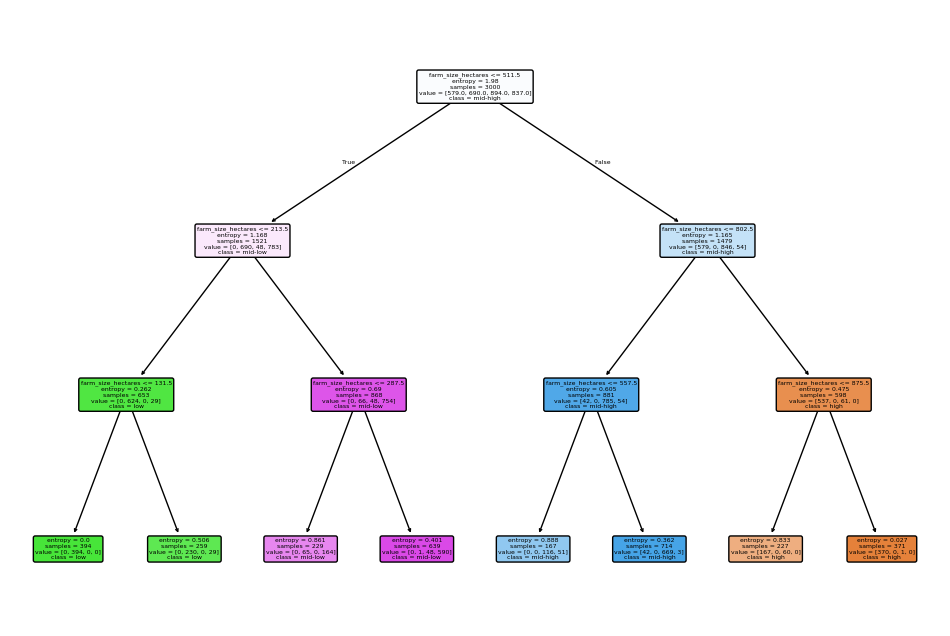

In [7]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("crop_yield_data.csv")

# Convert continuous target into 4 bins
df["yield_class"] = pd.cut(df["crop_yield"], bins=4, labels=["low","mid-low","mid-high","high"])

# Features (input) and Target (output)
X = df.drop(columns=["crop_yield", "yield_class"])
y = df["yield_class"]

# Train a decision tree
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3, random_state=42)
clf.fit(X, y)

# Plot the decision tree
plt.figure(figsize=(12,8))
plot_tree(clf, feature_names=X.columns, class_names=clf.classes_, filled=True, rounded=True)
plt.show()

A7.

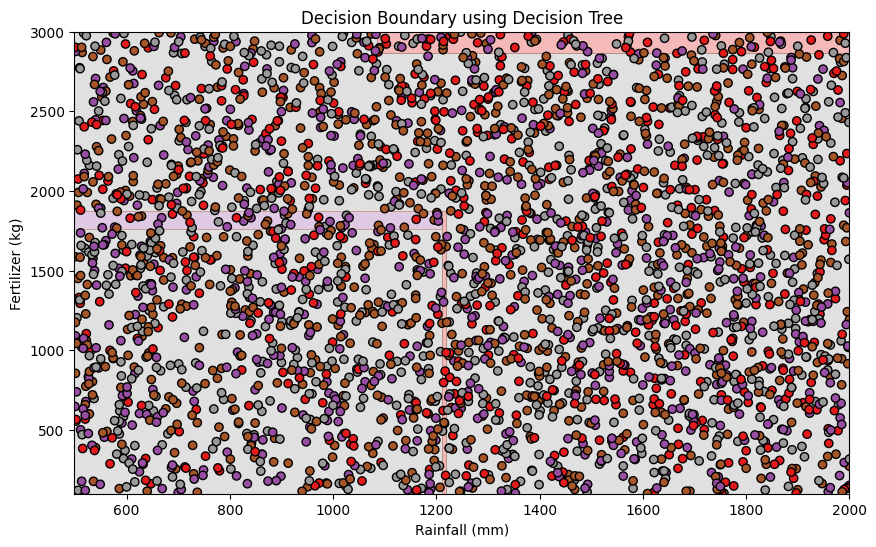

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

# Load dataset
df = pd.read_csv("crop_yield_data.csv")

# Convert continuous target (crop_yield) into 4 categories
df["yield_class"] = pd.cut(df["crop_yield"], bins=4, labels=["low","mid-low","mid-high","high"])

# Select 2 features
X = df[["rainfall_mm", "fertilizer_kg"]].values
y = df["yield_class"]

# Encode labels (convert strings → numbers)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train Decision Tree
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3, random_state=42)
clf.fit(X, y_encoded)

# Create mesh grid
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 1),
                     np.arange(y_min, y_max, 1))

# Predict on grid
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.figure(figsize=(10,6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Set1)
plt.scatter(X[:, 0], X[:, 1], c=y_encoded, edgecolor="k", cmap=plt.cm.Set1)
plt.xlabel("Rainfall (mm)")
plt.ylabel("Fertilizer (kg)")
plt.title("Decision Boundary using Decision Tree")
plt.show()